In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

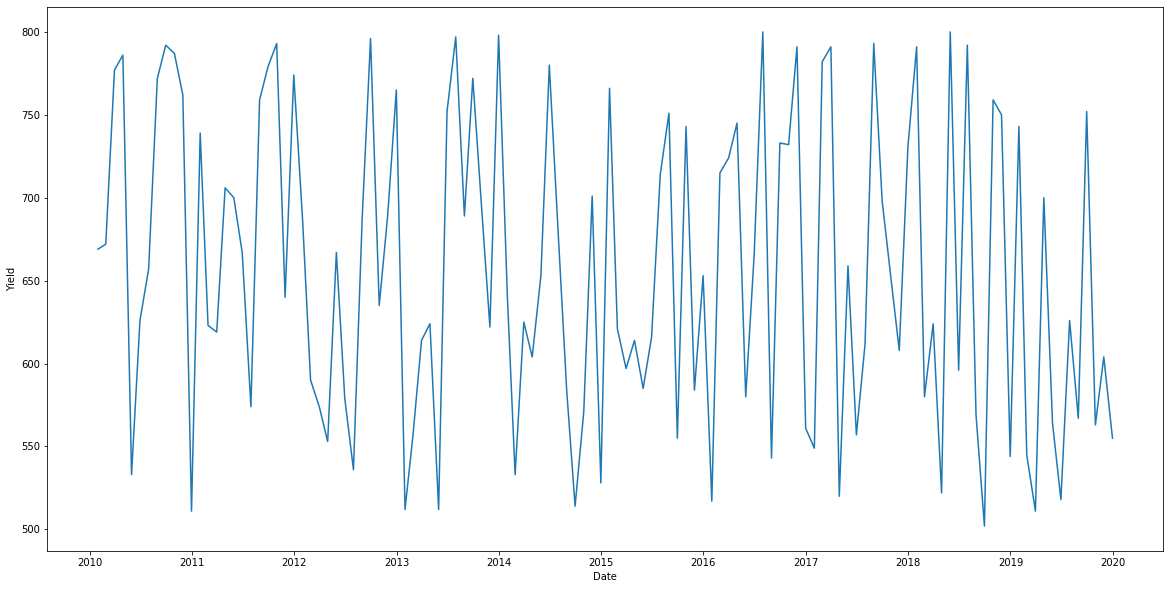

In [25]:
df = pd.read_csv('forecast.csv', parse_dates = ['Date'], index_col = ['Date'])
df.head()
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Yield')
plt.plot(df)

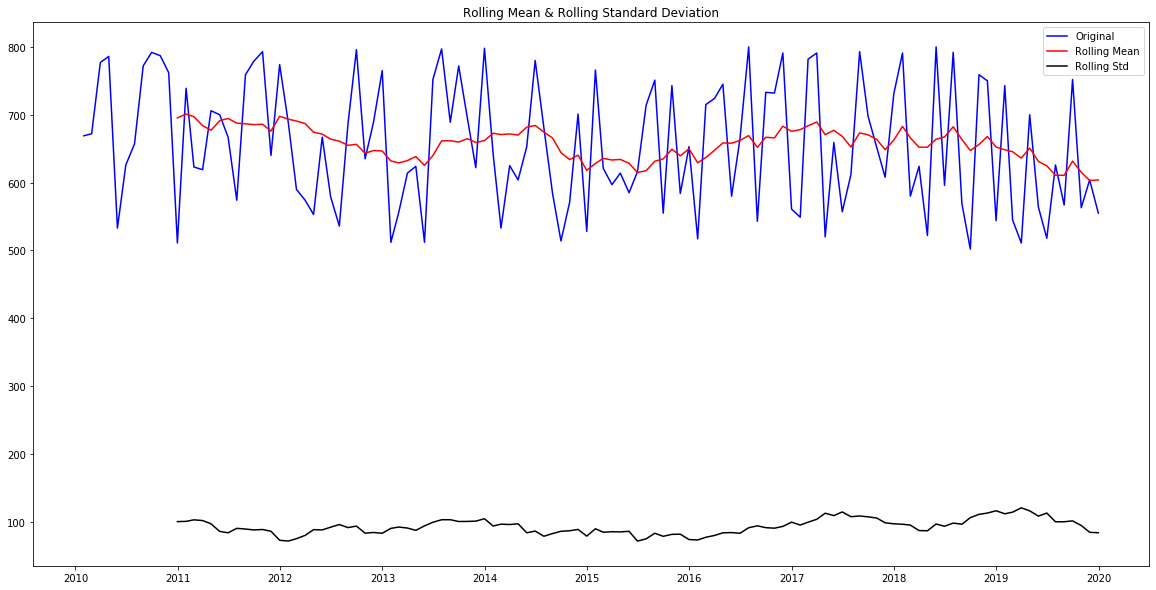

In [27]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.figure(figsize=(20,10))
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [5]:
result = adfuller(df['Yield'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -10.833443650275134
p-value: 1.685256119720711e-19
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


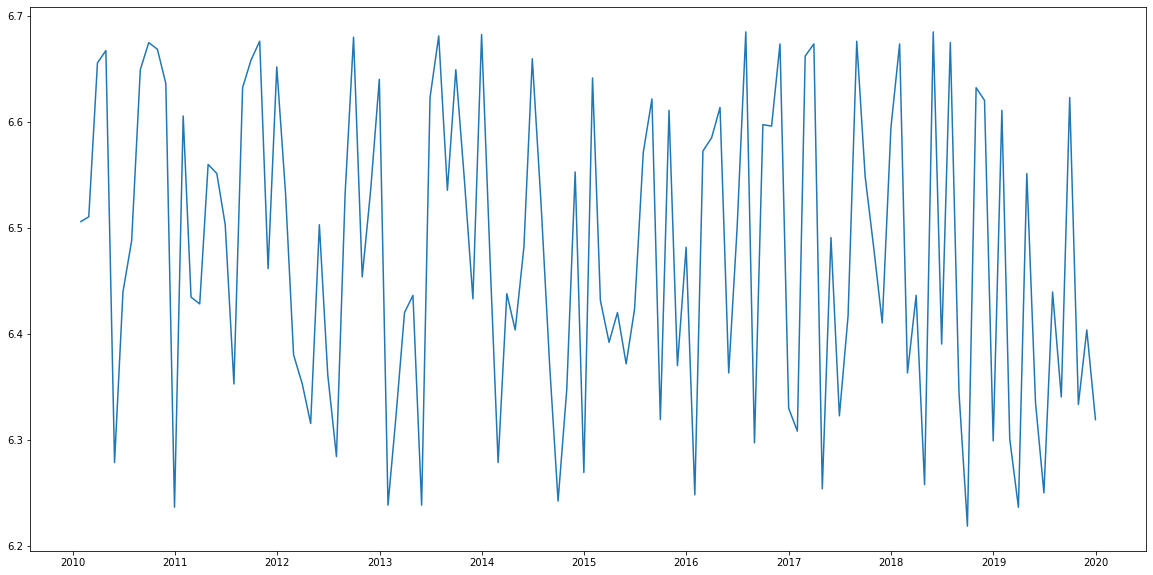

In [28]:
df_log = np.log(df)
plt.figure(figsize=(20,10))
plt.plot(df_log)

In [29]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    plt.figure(figsize=(20,10))
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Yield'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

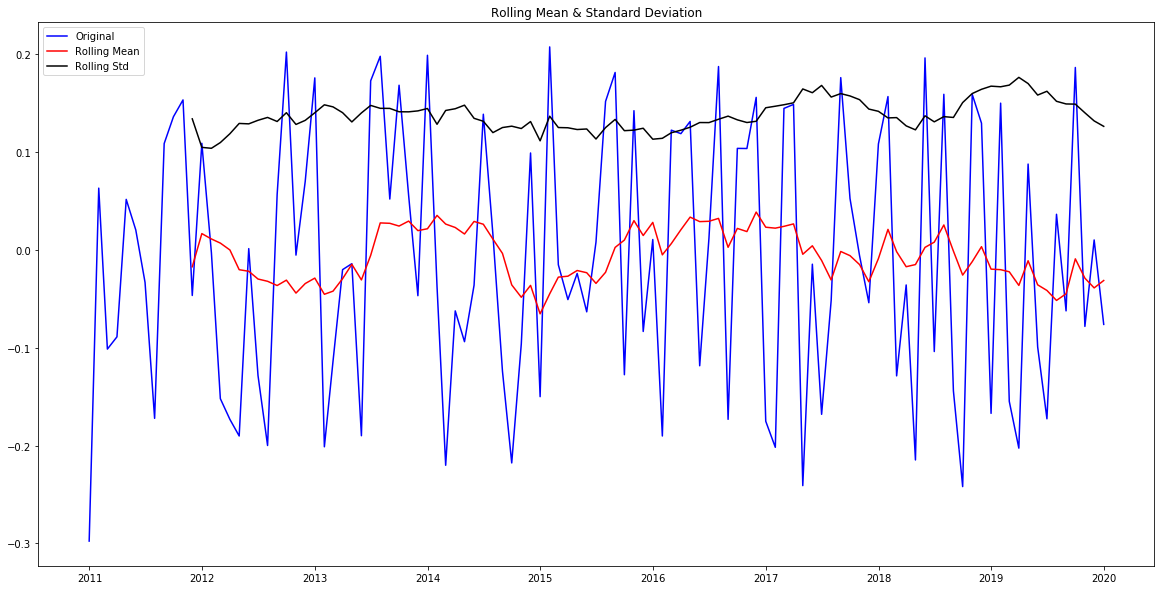

ADF Statistic: -11.321295019992792
p-value: 1.1723954685494344e-20
Critical Values:
	1%: -3.4924012594942333
	5%: -2.8886968193364835
	10%: -2.5812552709190673


In [30]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

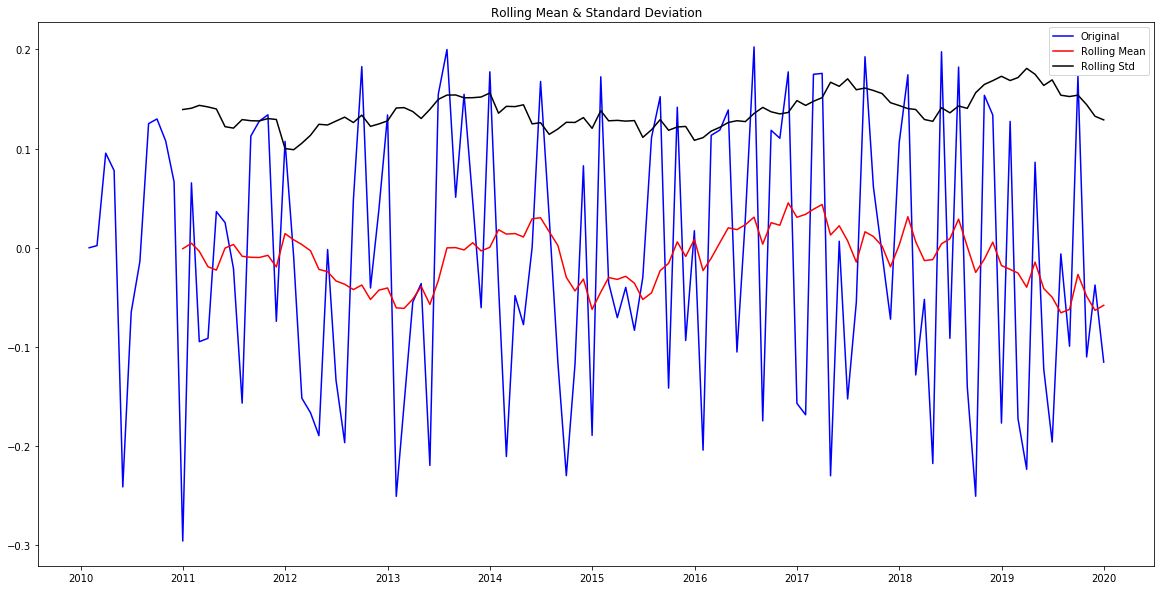

ADF Statistic: -11.492831296841606
p-value: 4.690931704424055e-21
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [31]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

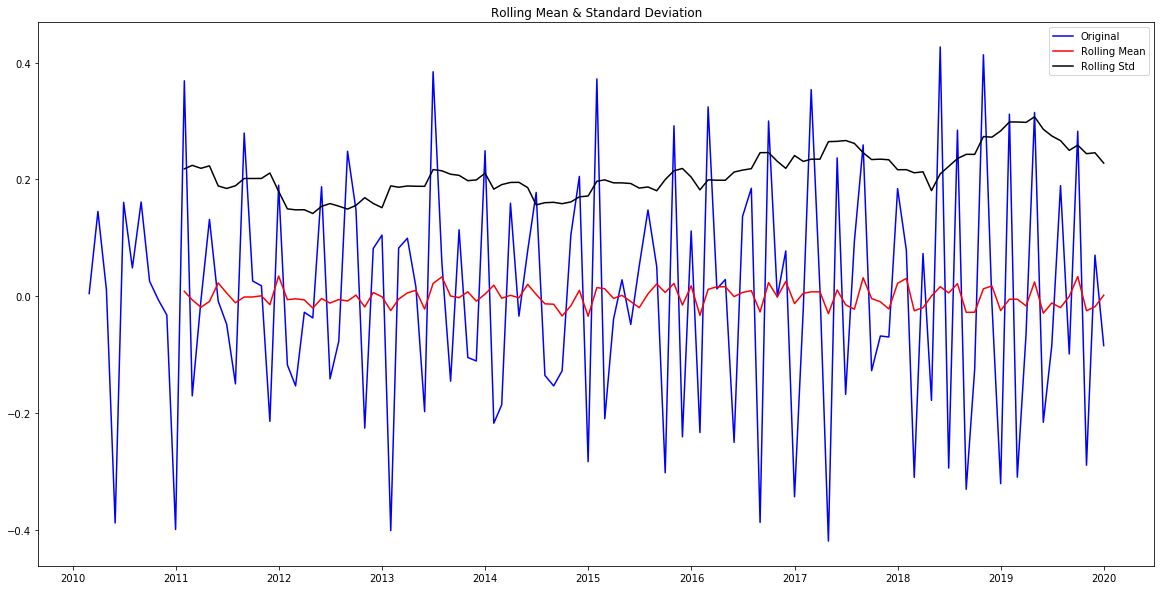

ADF Statistic: -7.127303923694943
p-value: 3.592407073367142e-10
Critical Values:
	1%: -3.49181775886872
	5%: -2.8884437992971588
	10%: -2.5811201893779985


In [32]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

/Users/aveer/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/aveer/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


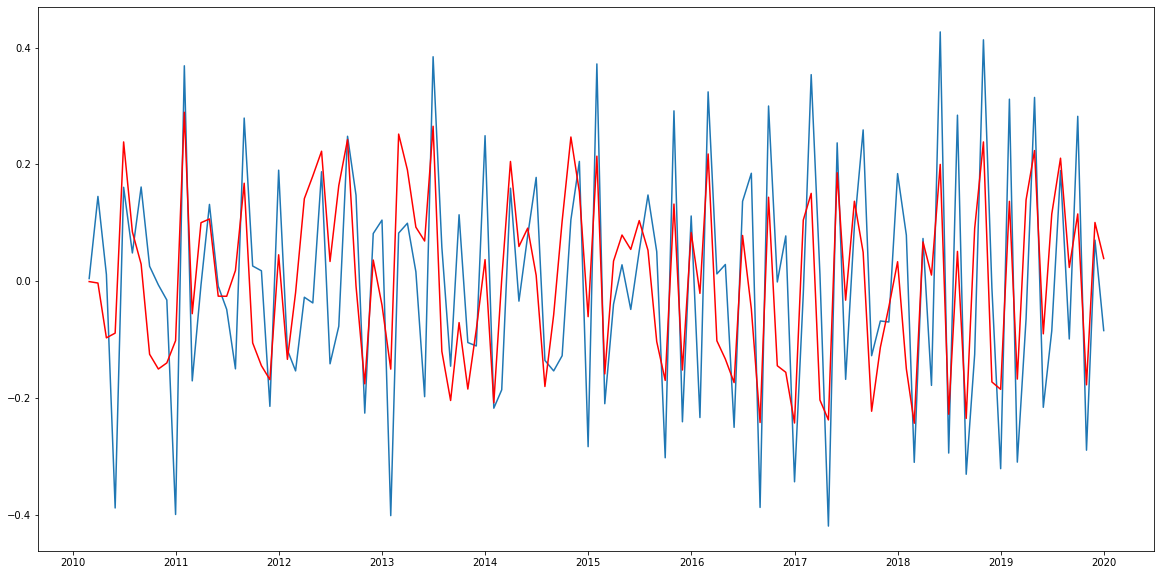

In [33]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.figure(figsize=(20,10))
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

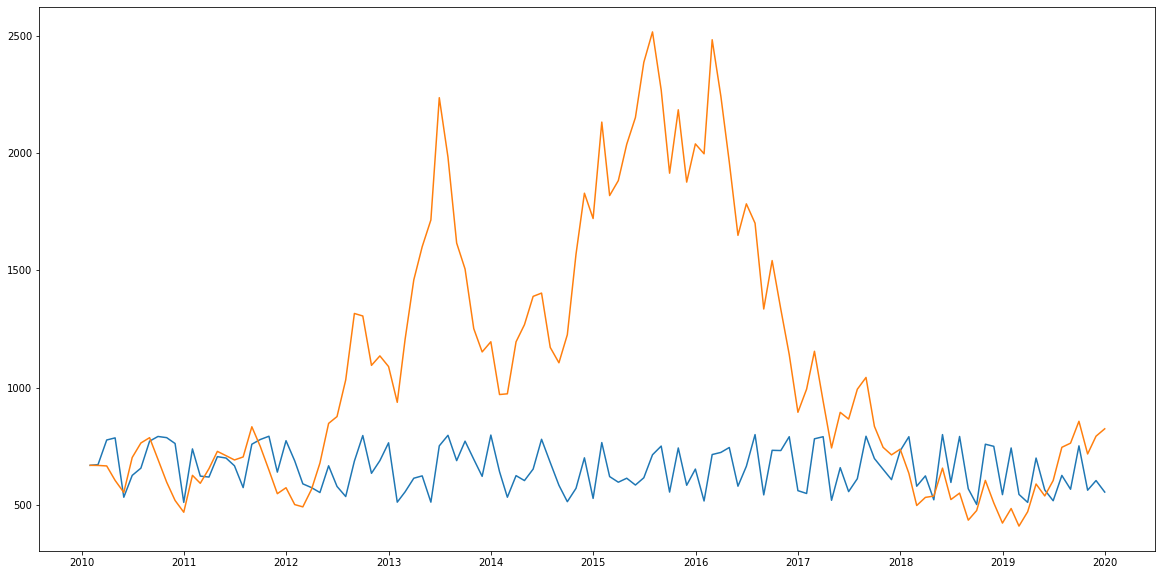

In [34]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Yield'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,10))
plt.plot(df)
plt.plot(predictions_ARIMA)

<Figure size 1440x720 with 0 Axes>

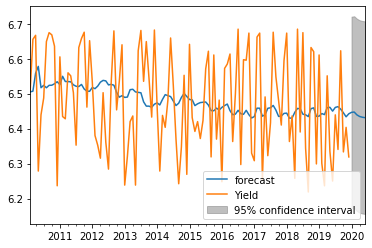

In [47]:
plt.figure(figsize=(20,10))
a=results.plot_predict(1,125)


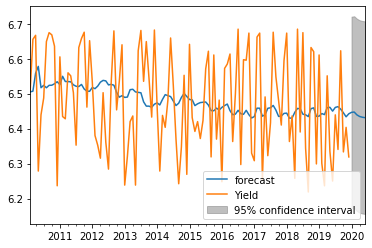